# Model Selection and Evaluation

In [1]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** At this point, we have a general framework for developing probabilistic models, as well as one way of fitting them to data, MLE. We've then instantiated this framework to develop two types of predictive models---regression and classification. We further learned how to build in expressivity using tools from deep learning---namely, neural networks---into these models. Are we finally ready to apply these models to real-life tasks? 

Unfortunately, there's one key piece we're still missing: so far, we've only used 1- and 2-dimensional input data and 1-dimensional output data. While in principle, we already have the tools to implement predictive models for higher dimensional data, we don't yet have the tools to *evaluate* them. We've purposefully worked with lower dimensional data because it is easy to visualize, and therefore easy to qualitatively evaluate. But as data becomes higher dimensional, it's much more difficult to get intuition using visualizations. As a result, we will have to rely on *metrics*. 

**Challenge:** There are many ways of measuring model performance. Which metrics should we use? What are the pros and cons of each metric? We will answer these questions here. Even though our motivation for developing evaluation metrics is our inability to visualize high-dimensional data, we will in fact focus on low-dimensional data, again. This is because we need to gain intuition about each metric we introduce. 

**Outline:**
* What's underfitting/overfitting? How do we prevent it?
* Introduce log-likelihood
* Introduce metrics specific to regression
* Introduce metrics specific to classification
* Introduce a framework for broader impact analysis

**Data.** You've started a collaboration with doctors from IHH's Center for Rare Disorders. The doctors are interested in better understanding Antenna Inflammation, in which a being's antennas sporadically inflame for weeks at a time. This causes them to malfunction and is quite painful. Because the disease is so rare, it's been difficult to gather enough information to develop a treatment. Currently, the only known treatment is to expose the inflamed antennas to high-energy space beams. While these beams do not cure the disease, they do alleviate the pain. Doctors are interested in better understanding what beam intensity to use; they suspect that a low-intensity beam might not help much, but too high of an intensity might also contribute to pain. They have collected data for you to analyze. Let's take a look:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import jax.numpy as jnp
import jax.random as jrandom
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CRD-train.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Intensity,Comfort
Patient ID,,
45,0.308006,0.977233
59,0.502982,1.359451
7,0.125683,0.405900
50,0.520344,1.185005
92,0.404359,0.955264
27,0.471006,1.138226
131,0.767512,1.025494
137,0.534193,0.828949
122,0.661706,1.179636


**Models.** In addition to the data the doctors have collected, they've gone ahead and fit some models to the data. They haven't told you much about the modeling choices they made, but still want your help selecting which model best to use. Let's load up the models:

In [3]:
models = load_all_regression_models_of_comfort_vs_intensity()

print('Number of models loaded:', len(models))

Number of models loaded: 6


We've created a helper function for you to visualize all of the models. Let's have a look:

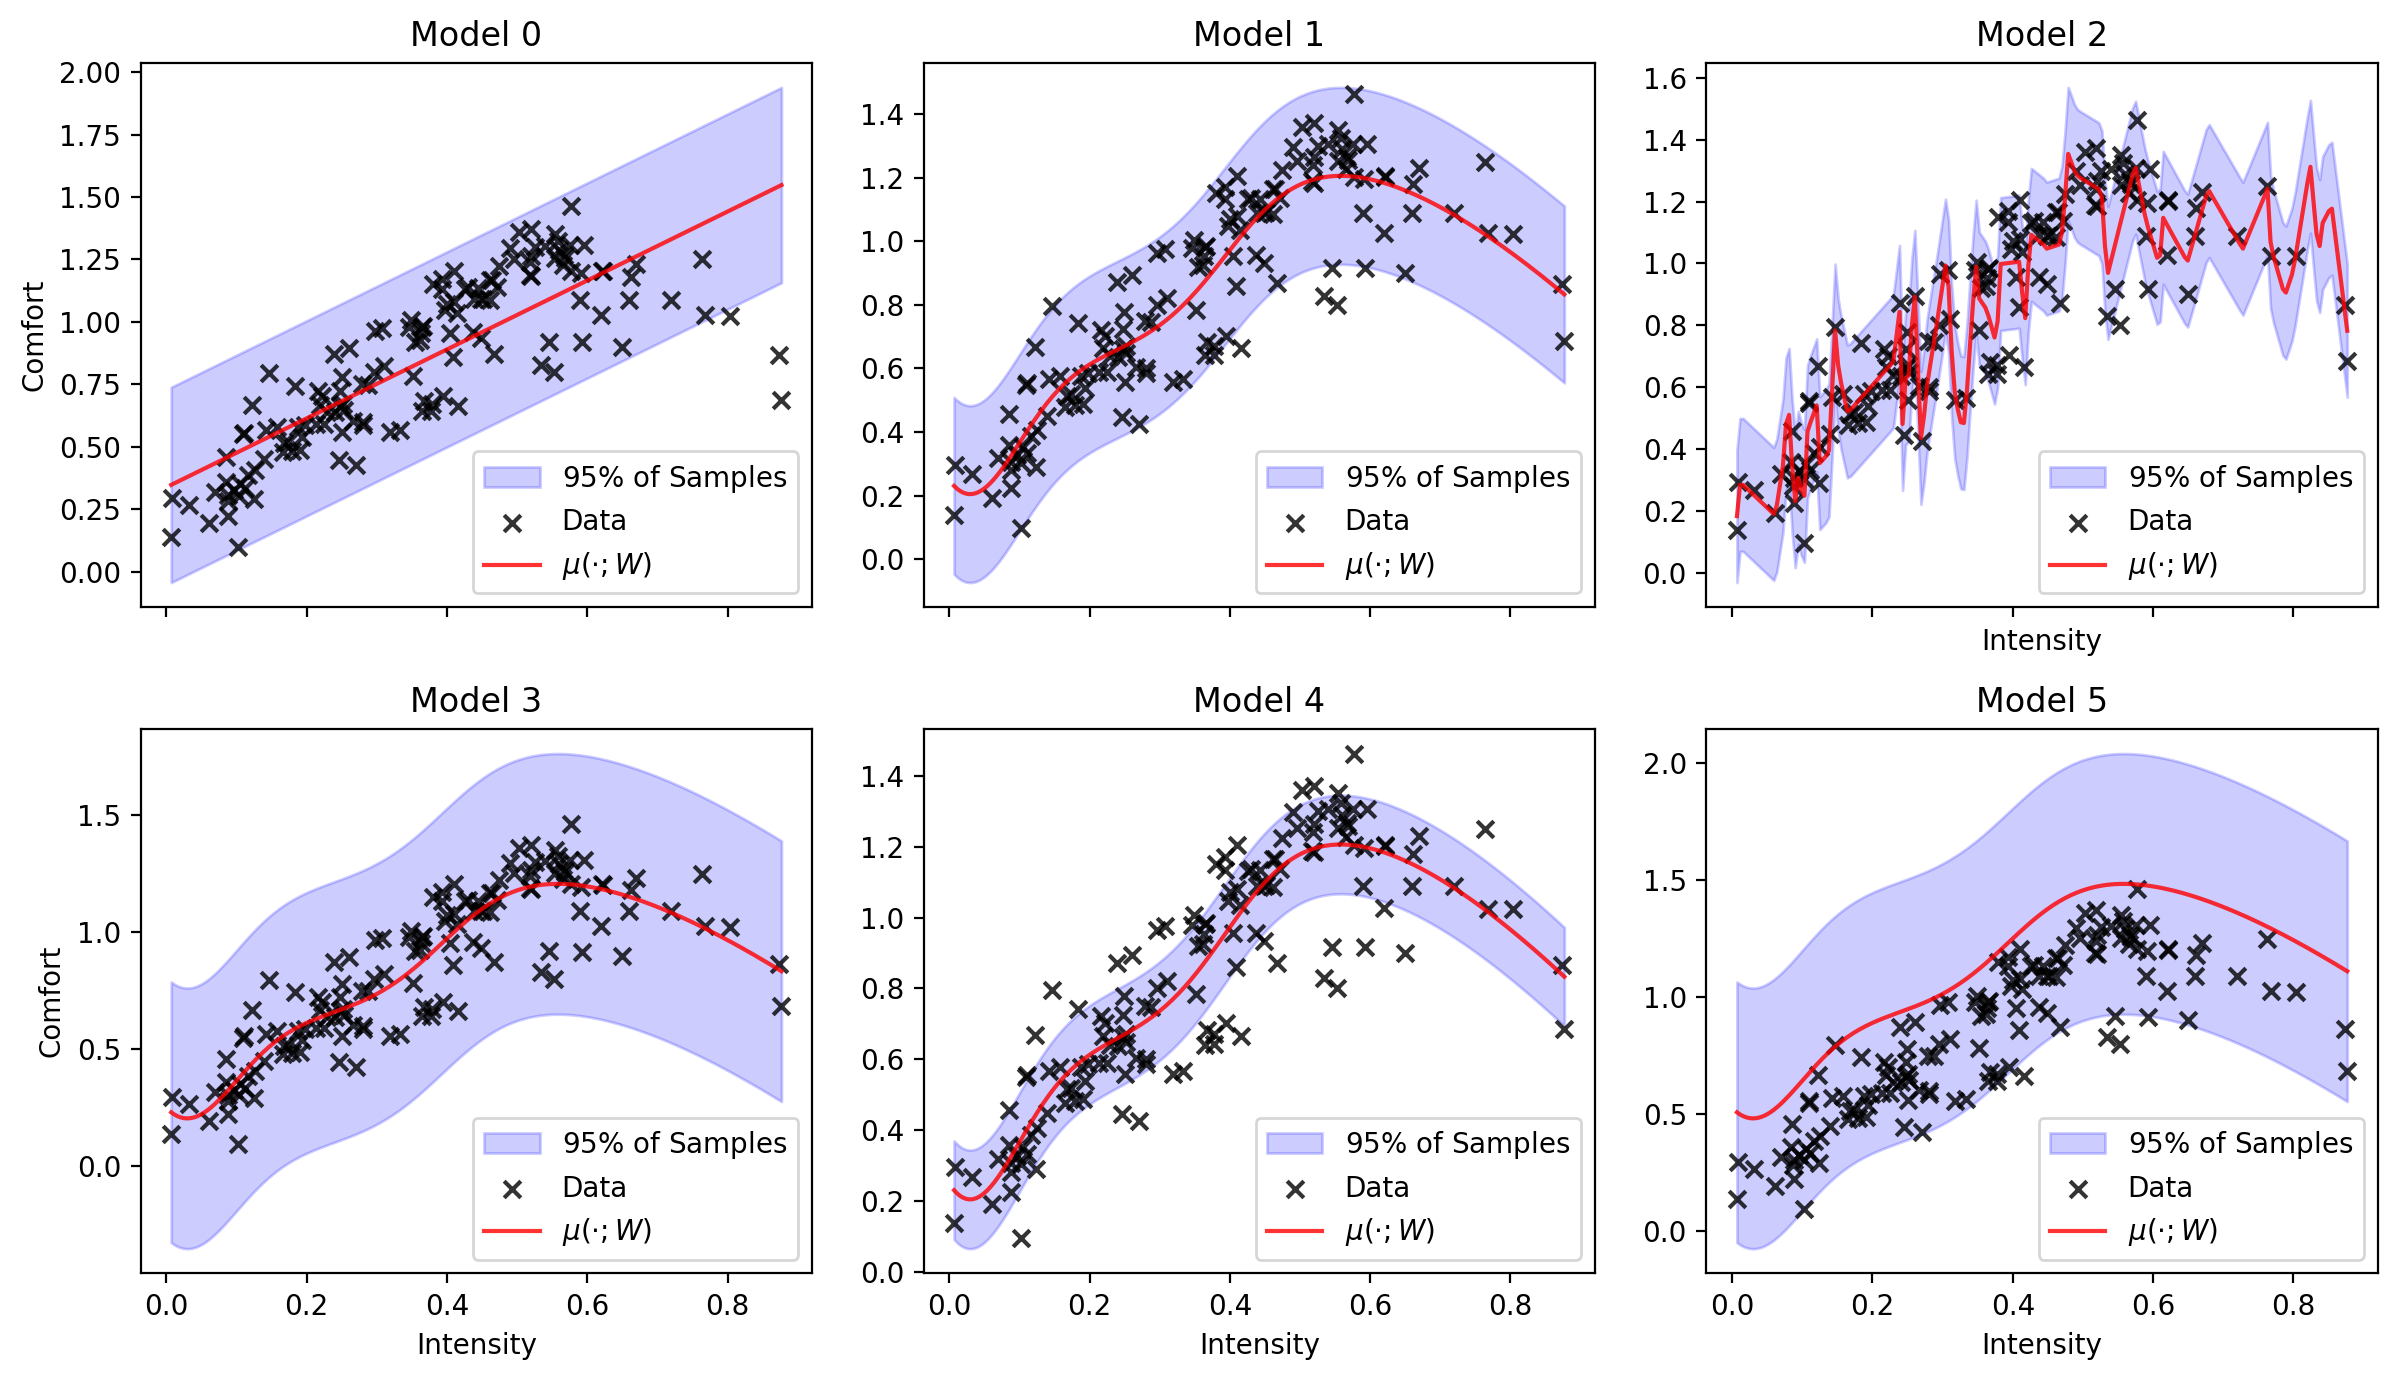

In [4]:
plot_all_regression_models_of_comfort_vs_intensity(data, models)

## Preventing Over- and Under-fitting

**Decomposition into Signal vs. Noise.** In probabilistic models, we often term one part of the model the "trend" or the "signal," and we term the rest "noise" or "observation error." For example, recall that in regression, our trend is captured by a function of the inputs, $\mu(\cdot; W)$, around which we assume a Gaussian observation error. Similarly, in the classification model we introduced, our trend is captured by a function of the inputs, $\rho(\cdot; W)$, which computes the probability of belonging to class 1 (as opposed to class 0). We then sample from a Bernoulli distribution with that probability---this represents the "noise" or "observation error." When fitting a probabilistic model, we're always at risk of learning models that mix up what's signal vs. what's noise. This can happen in two ways: 
* **Overfitting:** When the "signal" part of the model memorizes the "noise" part, and as a result, interpolates poorly. By *interpolation*, we mean, how well the model fits data points *near* our training data. 
* **Underfitting:** When a model doesn't capture enough of the "signal" in the data (assuming it's noise), and as a result, interpolates poorly.

Let's illustrate what overfitting and underfitting each look like, in both classification and regression:

```{figure} _static/figs/model-fitting-illustration.png
---
width: 650px
name: model-fitting-illustration
align: center
---

Illustration of overfitting and underfitting, adapted from [this image](https://i.pinimg.com/originals/72/e2/22/72e222c1542539754df1d914cb671bd7.png).
```

**Preventing Inappropriate Decomposition into Signal vs. Noise.** How can we tell if a model overfit or underfit? Well, looking at the definition above, we said a model over/under-fitts if it *interpolates* poorly. This means that, to determine if a model over/under-fit, we should check its fit *on data it has not seen yet*---specifically, on data that's similar to our training data. 

But where can we get such extra data points? Oftentimes, it's hard to collect additional data. For example, at the IHH, data collection is expensive; it's funded by large government grants and requires approval of an [Institutional Review Board (IRB)](https://en.wikipedia.org/wiki/Institutional_review_board) to ensure data collection and analysis is ethical. As a result, we often cannot collect additional data. Instead, however, we can *split our data into parts*---one part for training and one part for validating the model's interpolation. Specifically, after fitting the model on the training data, we compare the model's fit on the training data with its fit on the validation data:
* If the fit on the training data is better than that on the validation data, we *overfit*.
* If the fit on neither the training data nor the validation data is good, we *underfit.*
* If the fit on both the training and validation data is comparably good, we fit just right!

The bottom row of {numref}`model-fitting-illustration` above shows the loss function evaluated on both the training data and the validation set over iterations (or "epochs") of gradient descent. 

**Reporting Model Performance.** In practice, we often aren't just interested in the fitted model---we also want to report some *metric* to quantify how well it fits. To accomodate this need, we split the data into three parts: a training set, a validation set, and a test set. 
* We fit the model to the *training* data.
* We use the *validation* set to determine over/under-fitting (by comparing the fit on the validation vs. training data, as described above).
* Finally, we report the model's performance on the *test* set.

Often, we use $70\%$ of the data for the training, $20\%$ for validation, and $10\%$ for testing. 

**But which metric should we use?** That's a million-dollar question! We will next present several common metrics for evaluating model performance numerically. As you will see, model performance is multi-faceted---there's more to consider than just how well the model fits. For example, is the model fair? and will the model be understandable to a human? If we have multiple factors to consider, how can we possibly design a metric that gives us a single ranking of models from best to worst? The answer is: we can't. We will have to use multiple metrics to evaluate our models. At times, these metrics will present us with contradictory information, and we will have to determine what to do. 

## Log-Likelihood

**A General Purpose Metric.** Since so far, we fit our models by finding parameters that maximize the data log-likelihood (MLE). Can we also use log-likelihood as an evaluation metric? If we trust this metric for *fitting* our model, surely we should trust it for *evaluation* as well. And what's nice about log-likelihood is that, unlike some of the other metrics we'll introduce next, it's not model-specific. We can evaluate the log-likelihood of *any* probabilistic model.

**Log-Likelihood as an Evaluation Metric.** Recall that the data log-likelihood is,
\begin{align}
\log p(\mathcal{D}; \theta) &= \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta),
\end{align}
where $\mathcal{D}$ is our entire data set of $N$ observations, each $\mathcal{D}_n$ is an observation, and $\theta$ is the model parameters. However, notice that in this definition, the data log-likelihood grows as $N$ increases due to the sum. This means that, if our train, validation and test sets each have a different number of points, we cannot compare their log-likelihoods directly. To fix this problem, we instead compute the *average* log-likelihood (this is just the above equation divided by $N$):
\begin{align}
\text{Avg. Log-Likelihood} = \frac{1}{N} \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta).
\end{align}

````{admonition} Exercise: Getting Intuition for Log-Likelihood

**Part 1:** Looking at the plots of the models above, rank them from what you'd consider best to worst. How did you arrive at this ranking? Please relate your answer to the broader context of the problem. 

**Part 2:** For each model, evaluate the average log-likelihood on the training, validation, and test set. Do this by,
* Loading in the list of models (using the function we provided above). Each model in the list has the following signature:
    ```
    def model(N, x, y=None):
        # Expects x to be of shape (N, 1)
        # Expects y to be of shape (N, 1)
        pass # already implemented
    ```
    Here, `N` is the number of points, `x` are the inputs, and `y` are the outputs. 
* Loading the training, validation, and test data sets from `data/IHH-CRD-train.csv`, `data/IHH-CRD-val.csv`, and `data/IHH-CRD-test.csv`. 
* Finally, compute the average log-likelihood. Please use the helper function we created, `cs349_joint_data_log_likelihood(model, *args, **kwargs)`, where `*args, **kwargs` capture all arguments your model takes in: `N, x, y=None`. Note that our helper function computes the *joint data* log-likelihood, not the average log-likelihood. 

**Part 3:** Rank the models using log-likelihood on the training set and report log-likelihood test set. Did this method succeed in ranking the best-fitting model on top? Next, rank the models using validation set and report the test log-likelihood. Did this method successfully rank the best-fitting model on top?

**Part 4:** How did the ranking you got from using the validation set compare with your initial ranking from part (1)? What does log-likelihood penalize models for?
````

**Human-meaningful Notions of Model-fit.** So log-likelihood seems to work well when *comparing* models; given a collection of trained models, we can use log-likelihood on the validation set to select a model that is likely to fit the test set well. However, suppose we're given a single model---how do we know if this model is good? For example, if our model's log-likelihood is $0.123$, is that good? is that bad? The *units* of log-likelihood hold little meaning to us. Because of this, log-likelihood is difficult to interpret on its own, leading us to search for other metrics we can more easily interpret. 

## Metrics for Regression

**Mean Squared Error (MSE).** Since log-likelihood is hard to interpret on its own, we will now introduce another metric, MSE, specific to regression. This metric can be used together with log-likelihood to paint a clearer picture of model fit. This is, of course, not the only evaluation metric for regression, but it's a common one, so we'll focus on it here. For 1-dimensional output data, the MSE is defined as follows:
\begin{align}
\text{MSE} &= \frac{1}{N} \sum\limits_{n=1}^N (\underbrace{y_n - \widehat{y}_n}_{\text{error}})^2,
\end{align}
where $y_n$ is an observation and $\widehat{y}_n$ the model's prediction. As the name suggests, we compute the error between our model's prediction and the observation, square it, and average. The MSE can be thought of as a measure of "spread" (or, in statistical lingo, the *variance*) of the data around the model's prediction. Hopefully, in contrast to log-likelihood, it's a little easier to understand, since we may have domain knowledge of what error, $y_n - \widehat{y}_n$, is considered high/low.

But for a probabilistic model, what is the model's "prediction"? In a probabilistic regression model, we have a *distribution* of outputs given inputs, $p_{Y | X}$, and a distribution is *not* a single prediction. Because of this, we have to summarize the conditional distribution using a single value. Here, we will use the mean (which also happens to be the mode---or the most likely value of $y$). For our regression model, the mean of the distribion is the "trend," so
\begin{align}
\hat{y}_n &= \mu(x_n; W^\text{MLE}).
\end{align}

````{admonition} Exercise: Implement and Use MSE
**Part 1:** Write a function to compute the MSE. The models are set up such calling `cs349_sample_generative_process` will return a Python dictionary with key `mu`, containing $\mu(x_n; W^\text{MLE})$. 

**Part 2:** For each model, evaluate the MSE on the training, validation, and test set. 

**Part 3:** Rank the models using validation MSE and report the test MSE. Does this ranking disagree with the log-likelihood ranking? If so, where? *Hint: look at the observation noise.*

**Part 4:** Are there any other factors we should have considered in our evaluation of the models? Let's load the training, validation, and test data sets from `data/IHH-CRD-train-augmented.csv`, `data/IHH-CRD-val-augmented.csv`, and `data/IHH-CRD-test-augmented.csv`. These data sets are the same as before, just with a previously omitted feature: race. As it turns out, the intervention (the space beam), was only tested on one of these races and not the other. Create a scatter plot of the training data using color to distinguish between the two races. 
* What's different about the trend for the two races? What's the same?
* How do you think this will affect the model's predictive performance on each of the two races? Why?

**Part 5:** Re-compute the log-likelihood and MSE of each model on each of these data sets, this time evaluating each metric separately for each race. For which race does the model perform better on? 
````

## Metrics for Classification

**Accuracy.** Since log-likelihood is hard to interpret on its own, we will now introduce another metric, accuracy, that's specific to classification. Simply put, accuracy is the fraction of predictions the model got correct:
\begin{align}
\text{Accuracy} &= \frac{1}{N} \underbrace{\sum\limits_{n=1}^N \mathbb{I}(y_n = \widehat{y}_n),}_{\text{count correct predictions}}
\end{align}
where, as before, $\widehat{y}_n$ is the model's prediction, and $\mathbb{I}(\cdot)$ is an indicator function---a function that evaluates to $1$ when the condition inside is true and $0$ otherwise. The sum over the indicators counts the number of correct predictions. When divided by $N$, we get the fraction of correct predictions. 

Just like before, a probabilistic model does not make "predictions;" it models a full distribution over outputs given inputs. We, again, have to choose how to summarize this distribution using a single value. Remember that in our classification model, $\rho(x_n)$ outputted the probability of $x_n$ belonging to class 1 (vs. class 0). To turn this into a prediction, we will threshold it: if $\rho(x_n) \geq 0.5$, we'll say $x_n$ belongs to class 1---otherwise, it belongs to class 0. We can formalize this using an indicator function:
\begin{align}
\widehat{y}_n &= \mathbb{I}(\rho(x_n) \geq 0.5)
\end{align}

````{admonition} Exercise: The Shortcomings of Accuracy
**Context.** Since the disease is incredibly rare, occurring only in $0.1\%$ of the population, doctors don't yet know what are its causes. The doctors have managed to acquire a large fund to collect data about a large swath of the population, ranging from genetic factors to environmental factors (demographics, occupation, diet, physiology, etc.). They just finished collecting the data and have run a preliminary analysis to determine which factors contribute most. 

**Challenge.** Even though their model is $99.9\%$ accurate, they have found that none of the factors seem to matter to the model---how is this possible? They recruited you to help understand what's going on with their model. 

**Part 1:** You decided to inspect the parameters of the model. In the model, $1$ represents having the disease and $0$ represents no disease. Lucky for you, the doctors used a linear classification model (so interpreting it is possible): 
\begin{align}
p_{Y | X}(y_n | x_n; \theta) &= \mathrm{Ber}\left( \rho(x_n; \theta) \right) 
\end{align}
where
\begin{align}
\rho(x_n; \theta) &= \mathrm{sigmoid}\left( \theta^{(0)} + \sum\limits_{d=1}^{D_x} \theta^{(d)} \cdot x_n^{(d)} \right),
\end{align}
where the $(d)$-superscript notation represents the $d$th dimension, and $D_x$ is the dimensionality of the inputs $x_n$. When inspecting the parameters, you found that,
\begin{align}
\theta &= [\underbrace{-6.90675}_{\theta^{(0)}}, \underbrace{0.0, 0.0, \dots, 0.0}_{\theta^{(1)}, \dots, \theta^{(D_x)}}].
\end{align}
Looking at the parameters, $\theta$, which dimensions of the input matter most? 

**Part 2:** How can such a model achieve such high accuracy?

**Part 3:** Suppose the IHH were to deploy this model as a screening tool for beings coming into the IHH's emergency room. The model would be used to identify beings at high risk of Antenna Infection for early treatment. What problems may arise?
````

**Confusion Matrices.** Although accuracy is easy to evaluate and understand, it has some major shortcomings, as you've shown in the exercise above. Confusion matrices aim to address this issue by looking at the ways in which the model makes mistakes when it's incorrect. Why are they called "confusion" matrices? Maybe to alleviate our confusion? Unclear. Anyways, we define a confusion matrix as follows:
|  | **Predicted: Disease** | **Predicted: No Disease** |
|---|---|---|
| **Actual: Disease** | *True Positives:* The number of patients with the disease who were correctly classified as having the disease. | *False Negatives:* The number of patients with the disease who were incorrectly classified as not having the disease. |
| **Actual: No Disease** | *False Positives:* The number of patients without the disease who were incorrectly classified as having the disease. | *True Negatives:* The number of patients without the disease who were correctly classified as having no disease. |

As you can see, a confusion matrix presents a breakdown of the model's correct and incorrect predictions.

````{admonition} Exercise: Understanding Confusion Matrices
**Part 1:** Write down the confusion matrix for the classifier presented to you by the doctors in the previous problems (in terms of the number of patients in the data, $N$).

**Part 2:** To try to fix the problem, the doctors trained two more classifiers on their data set. As per your suggestion, they are now computing the confusion matrices for both (instead of looking at accuracy alone):
* Model 1:
    \begin{align*}
    \text{Accuracy} = 80.1\%, \quad \text{Confusion Matrix} = \begin{bmatrix} 500 & 9500 \\ 190000 & 800000 \\ \end{bmatrix}.
    \end{align*}
* Model 2:
    \begin{align*}
    \text{Accuracy} = 67.1\%, \quad \text{Confusion Matrix} = \begin{bmatrix} 700 & 324300 \\ 5000 & 670000 \\ \end{bmatrix}.
    \end{align*}  

For the screening tool described in the previous problem, which model would you prefer? Why?

**Part 3:** Make up a scenario in which you would prefer the model you didn't choose? What differentiates your scenario from the one about the screening tool?
````

## Broader Impact Analysis

**ML in Sociotechnical Contexts.** So far, we've focused on gaining intuition for qualitative metrics of model performance. We've seen that no single metric can paint a full picture of a model's fit. And that multiple metrics can provide contradictory information---a model can be "good" according to one metric by "bad" according to another. Most importantly, we've seen that no metric can be meaningful without its context---in some contexts, false negatives are more tolerable than false positives, and in others its the opposite. 

However, our analysis of ML models *should not stop here*. For us to responsibly develop and use ML (or any technological system), it's our responsibility not just to think about the technology, but also about their *sociotechnical context*---the software, hardware, data, model, people, affected communities, legal frameworks, business incentives, etc. that it will shape (or that will be shaped by its use). For this reason, we will now introduce a framework for conducting a broader impact analysis. This framework can serve as a starting point for thinking about ML in sociotechnical contexts. 

**Part A: Assessing Impact.** 
1. Identify the stakeholders and context:
    * Who are the users?
    * Who are the affected communities (are these the users)?
    * What is the relationship between the users and the affected communities? What are the power structures that relate users and affected communities?
    * What is the historical/cultural context of the type of task your tech performs (i.e. what is the relationship between what you are trying to accomplish, with respect to the users and affected communities, and the historical experience of these groups of people with past technologies that aimed to accomplish similar tasks)?
2. What are the potential benefits of your technology?
    * What kinds of needs do your users/communities have?
    * What kinds of constraints do your users/communities have?
    * How does your tech serve these needs?
3. What are the potential harms of your technology?
    * What kinds of side-effects and failures can your tech have? Does your tech increase or decrease the self-determination and agency of the users and affected communities?
    * What kinds of direct harm can these side-effects/failures cause?
    * What kinds of harm can the tech cause when embedded in the intended socio-technical system (trace out the effects through the web of relationships between stakeholders)?

**Part B: Responsibility.**
1. What are the ethical obligations of individual engineers?
    * What are your own ethical professional obligations in this project?
    * What design choices are dictated by your boss vs. what design choices do you make? 
    * To what extent are you (personally) ethically responsible for the impact of your company’s design decisions?
2. How much due diligence checking for harm should you do? 
    * How can you resolve a conflict of interests?
    * What are your obligations in situations where your assigned task works against public interest?
    * What do you do if the interest of your users conflicts with public interest?

**Part C: Inclusion, Diversity, and Participation.**
1. Inclusive design with diverse perspectives:
    * Do you personally understand the social (non-technical) dimensions of the potential impact of your tech? 
    * Has your product team, manager or company researched the social (non-technical) dimensions of the potential impact of your tech?
    * Are the values and perspectives of your users/affected communities meaningfully reflected throughout the development process (from design to evaluation)? 
2. Engage with affected communities:
    * Did you consult with domain experts, typical users, or representative community members in the inception, development, and deployment of the project?
    * Through what mechanisms can your domain experts, users/affected communities provide feedback during your inception, development, and deployment processes? If these mechanisms exist, what barriers may stop you from getting feedback?
    * How do you resolve conflicts of visions (e.g. between community members, between designers, between designer and user)?

````{admonition} Exercise: Conducting a Broader Impact Analysis
Choose one of the following articles:
1. [What happens when an algorithm cuts your health care](https://www.theverge.com/2018/3/21/17144260/healthcare-medicaid-algorithm-arkansas-cerebral-palsy)
2. [Dissecting racial bias in an algorithm used to manage the health of populations](https://www.science.org/doi/10.1126/science.aax2342)
3. [Rooting Out AI’s Biases](https://magazine.publichealth.jhu.edu/2023/rooting-out-ais-biases)

For the article you chose, imagine you are the engineer who developed the technology. Conduct a broader impact analysis. 
````